In [1]:
import os, pickle, cPickle, sys, urllib, gzip, sys
sys.setrecursionlimit(10000)

In [2]:
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image
import theano
import theano.tensor as T
import lasagne
from theano import config

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: Graphics Device (CNMeM is disabled)


In [3]:
import lasagne
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer, MergeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh, sigmoid
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

In [4]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print 'Using cuda_convnet (faster)'
except ImportError, e:
    print e
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print 'Using lasagne.layers (slower)'

Using cuda_convnet (faster)


In [5]:
fname = 'mnist/mnist.pkl.gz'
if not os.path.isfile(fname):
    testfile = urllib.URLopener()
    testfile.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", fname)
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()
X, y = train_set
X = np.rint(X * 256).astype(np.int).reshape((-1, 1, 28,28)) # convert to (0,255) int range (we'll do our own scaling)
mu, sigma = np.mean(X.flatten()), np.std(X.flatten())

In [692]:
eps = 1e-5

X_train = X.astype(np.float64) / 255

def make_binarised_set(X, copies = 20):
    samples = X_train.shape[0]
    out = np.zeros(tuple([copies * samples] + list(X_train.shape[1:])))
    for k in range(copies):
        rand = np.random.rand(*X_train.shape)
        next_ = rand < X_train
        out[k * samples: (k + 1) * samples] = next_.astype(np.float32)
    return out

10268074.0

In [693]:
X_train = make_binarised_set(X_train, copies = 5)
X_train = (1 - 2 * eps) * X_train + eps
#X_train =(X_train - mu) / sigma
X_train = X_train.astype(np.float32)

# we need our target to be 1 dimensional
X_out = X_train.reshape((X_train.shape[0], -1))

In [694]:
X_train.min(), X_train.max()

(9.9999997e-06, 0.99998999)

In [695]:
from lasagne.layers import Layer
from lasagne.random import get_rng

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

class Q_Layer(MergeLayer):
    
    
    def __init__(self, incomings, **kwargs):
        super(Q_Layer, self).__init__(incomings, **kwargs)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        
    def get_output_shape_for(self, input_shapes):
        assert input_shapes[0] == input_shapes[1]
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, log_sigma = inputs
        
        out_shape = mu.shape
        
        return self._srng.normal(out_shape) * T.exp(log_sigma) + mu

In [64]:
conv_num_filters = 16
filter_size = 3
pool_size = 3
encode_size = 16
dense_mid_size = 128
pad_in = 'valid'
pad_out = 'full'
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (Conv2DLayerFast, {'num_filters': 2*conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'num_units': 800}),
    (ReshapeLayer, {'shape': (([0], 2*conv_num_filters, 5, 5))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Conv2DLayerSlow, {'num_filters': 1, 'filter_size': filter_size, 'pad': pad_out}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [696]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 16
dense_mid_size = 128
pad_in = 'valid'
pad_out = 'full'

input_var = T.tensor4('inputs')
target_var = T.matrix('targets')

encode_hid = 800
z_hid = 10
decode_hid = 800

input_layer = InputLayer(shape=(None, X.shape[1], X.shape[2], X.shape[3]), input_var=input_var)

conv1 = Conv2DLayerFast(input_layer, num_filters= conv_num_filters, filter_size=filter_size, pad=pad_in)
conv2 = Conv2DLayerFast(conv1, num_filters= conv_num_filters, filter_size=filter_size, pad=pad_in)
pool1 = MaxPool2DLayerFast(conv2, pool_size=pool_size)
conv3 = Conv2DLayerFast(pool1, num_filters= 2*conv_num_filters, filter_size=filter_size, pad=pad_in)
pool2 = MaxPool2DLayerFast(conv3, pool_size= pool_size)

reshape1 = ReshapeLayer(pool2, shape=(([0], -1)))

encode_h_layer = DenseLayer(reshape1, num_units=encode_hid, nonlinearity=None)
mu_layer = DenseLayer(encode_h_layer, num_units=z_hid, nonlinearity=None)
log_sigma_layer = DenseLayer(encode_h_layer, num_units=z_hid, nonlinearity=None)
q_layer = Q_Layer([mu_layer, log_sigma_layer])
decode_h_layer = DenseLayer(q_layer, num_units=decode_hid, nonlinearity=tanh)
#network = DenseLayer(decode_h_layer, num_units= X.shape[2] * X.shape[3], nonlinearity=sigmoid)

reshape2 = ReshapeLayer(decode_h_layer, shape= ([0], 2*conv_num_filters, 5, 5))

upscale1 = Upscale2DLayer(reshape2, scale_factor=pool_size)
deconv1 = Conv2DLayerFast(upscale1, num_filters=conv_num_filters, filter_size=filter_size, pad=pad_out)
upscale2 = Upscale2DLayer(deconv1, scale_factor=pool_size)
deconv2 = Conv2DLayerSlow(upscale2, num_filters=conv_num_filters, filter_size=filter_size, pad=pad_out)
deconv3 = Conv2DLayerSlow(deconv2, num_filters=1, filter_size=filter_size, pad=pad_out, nonlinearity = sigmoid)

network = ReshapeLayer(deconv3, shape=(([0], -1)))    



In [626]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 16
dense_mid_size = 128
pad_in = 'valid'
pad_out = 'full'

input_var = T.tensor4('inputs')
target_var = T.matrix('targets')

encode_hid = 800
z_hid = 50
decode_hid = 800

input_layer = InputLayer(shape=(None, X.shape[1], X.shape[2], X.shape[3]), input_var=input_var)

reshape1 = ReshapeLayer(input_layer, shape=(([0], -1)))

encode_h_layer = DenseLayer(reshape1, num_units=encode_hid, nonlinearity=None)
encode_h_layer2 = DenseLayer(encode_h_layer, num_units=encode_hid, nonlinearity=None)
mu_layer = DenseLayer(encode_h_layer2, num_units=z_hid, nonlinearity=None)
log_sigma_layer = DenseLayer(encode_h_layer2, num_units=z_hid, nonlinearity=None)
q_layer = Q_Layer([mu_layer, log_sigma_layer])
decode_h_layer = DenseLayer(q_layer, num_units=decode_hid, nonlinearity=tanh)
decode_h_layer2 = DenseLayer(decode_h_layer, num_units=decode_hid, nonlinearity=tanh)


network = DenseLayer(decode_h_layer2, num_units=784, nonlinearity=sigmoid)  



In [697]:
prediction = lasagne.layers.get_output(network)

In [698]:
def kl_error(mu, log_sigma):  
    return 0.5 * T.sum(1 + 2 * log_sigma - T.exp(2 * log_sigma) - T.sqr(mu), axis = 1)

x_mu = get_output(mu_layer)
x_logs = get_output(log_sigma_layer)

kl_loss = kl_error(x_mu, x_logs).mean()

rec_loss_raw = lasagne.objectives.binary_crossentropy(prediction, target_var)
kl_loss_raw = kl_error(x_mu, x_logs)
rec_loss = lasagne.objectives.binary_crossentropy(prediction, target_var).sum(axis = 1).mean()
#rec_loss = lasagne.objectives.squared_error(prediction, target_var).sum(axis = 1).mean()

loss = rec_loss - kl_loss * 3.5

In [699]:


params = lasagne.layers.get_all_params(network, trainable=True)
#updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.001, momentum=0.9)
updates = lasagne.updates.adam(loss, params)

#test_prediction = lasagne.layers.get_output(network, deterministic=True)
#test_loss = lasagne.objectives.squared_error(test_prediction, target_var)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], [loss, rec_loss, kl_loss, 
                                                     kl_loss_raw, rec_loss_raw], updates=updates)

# Compile a second function computing the validation loss and accuracy:
#val_fn = theano.function([input_var, target_var], test_loss)

In [700]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [701]:
num_epochs = 10
import time
import sys

# Finally, launch the training loop.
print "Starting training..."
# We iterate over epochs:
for epoch in range(num_epochs):
    sys.stdout.flush()
    # In each epoch, we do a full pass over the training data:
    mse_err = 0
    kl_err = 0
    loss_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, X_out, 100, shuffle=True):
        inputs, targets = batch
        new_loss, new_mse, new_kl, kl_loss_raw, rec_loss_raw = train_fn(inputs, targets)
        mse_err += new_mse
        kl_err += new_kl
        loss_err += new_loss
        train_batches += 1
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch, num_epochs, time.time() - start_time))
        print("  rec loss:\t\t{:.6f}".format(mse_err / train_batches))
        print("  kl loss:\t\t{:.6f}".format(- kl_err / train_batches))
        print("  training loss:\t{:.6f}".format(loss_err / train_batches))
        #print kl_loss_raw.shape
        #print rec_loss_raw.shape

Starting training...
Epoch 0 of 10 took 60.501s
  rec loss:		123.973004
  kl loss:		9.736126
  training loss:	158.049445
Epoch 5 of 10 took 60.559s
  rec loss:		102.054848
  kl loss:		10.844634
  training loss:	140.011068
Epoch 9 of 10 took 60.763s
  rec loss:		100.526656
  kl loss:		10.934982
  training loss:	138.799092


In [702]:
output = lasagne.layers.get_output(network)
ae_encode = theano.function([input_var], output)
X_train_pred = ae_encode(X_train[:1000]).reshape(-1, 28, 28) * 255
X_pred = np.rint(X_train_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')
print X_pred.shape , X.shape

(1000, 28, 28) (50000, 1, 28, 28)


417


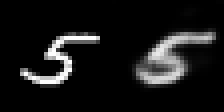

In [703]:
###  show random inputs / outputs side by side

def get_picture_array(X, rescale=4):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images(index):
    print index
    original_image = Image.fromarray(get_picture_array(X[index]))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(X_pred[index]))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('data/test.png', format="PNG")
    return IPImage('data/test.png')

#compare_images(2)
compare_images(np.random.randint(1000))

In [705]:
encoded = lasagne.layers.get_output(q_layer)
ae_encode = theano.function([input_var], encoded)
X_encoded = ae_encode(X_train[:10000])

print X_encoded.shape

(10000, 10)


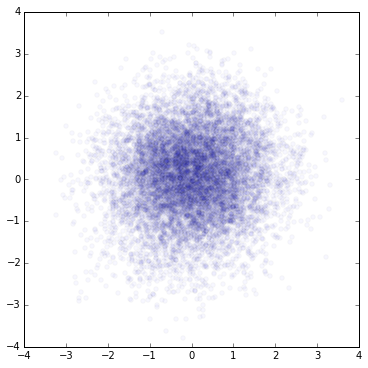

In [706]:
plt.figure(figsize=(6,6))
index1 = np.random.randint(z_hid)
index2 = np.random.randint(z_hid)

#plt.hist([x[0] for x in X_encoded], bins = np.linspace(-4,4, 100))

plt.scatter(X_encoded[:,index1],X_encoded[:,index2], alpha = 0.03)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()

In [730]:
noise_var = T.matrix('noise_inputs')

gen = get_output(network, {q_layer:noise_var})
#gen_q = get_output(q_layer, {mu_layer:zero_var, log_sigma_layer:neg_var})

# zero_input = np.zeros((10000,z_hid)).astype('float32')
# neg_input = np.full((10000,z_hid), 0).astype('float32')
noise_input = np.random.randn(10000,z_hid).astype('float32')

generate_fn = theano.function([noise_var], gen)

generated = generate_fn(noise_input)
generated = generated.reshape(-1, 28, 28) * 255
X_gen = np.rint(generated).astype(int)
X_gen = np.clip(X_gen, a_min = 0, a_max = 255)
X_gen =X_gen.astype('uint8')
print X_gen.shape


(10000, 28, 28)


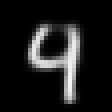

In [749]:
index = np.random.randint(1000)
gen_image = Image.fromarray(get_picture_array(X_gen[index]))
gen_image.save('data/test.png', format="PNG")
IPImage('data/test.png')